# Numerical simulations related to the paper *Multi-factor approximation of rough volatility models*

In [ ]:
import numpy as np
import scipy.special as sc
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.stats as ssn
import scipy.optimize
import math as mt
import scipy.integrate as integr

##  Parameters

In [ ]:
m = 200
n = 10
T = 1
rho = -0.7
H = 0.1
Gamma_const = mt.gamma(H + 0.5) * mt.gamma(0.5 - H)
lambd = 0.3
S0 = 1
dt = T / m
nu = 0.3
theta = 0.02
V0 = 0.02

## Computation of $\pi_n$, $\eta_i^n$, $c_i^n$ and $\gamma_i^n$

As suggested in the article, we're choosing:

$$
\pi_n = \frac{n^{-\frac{1}{5}}}{T}\left(  \frac{\sqrt{10}(1-2H)}{5-2H} \right)^{\frac{2}{5}}
$$
And for $0 \leqslant i \leqslant n$,
$$
\eta_i^n = i\pi_n
$$
And for $1 \leqslant i \leqslant n$,
$$
c_i^n = \frac{1}{\Gamma(H+\frac{1}{2})\Gamma(\frac{1}{2}-H)}\int_{(i-1)\pi_n}^{i \pi_n} \gamma^{-H-\frac{1}{2}}d\gamma = \frac{\pi_n^{\frac{1}{2} - H}}{(\frac{1}{2} - H)\Gamma(H + \frac{1}{2}) \Gamma(\frac{1}{2} - H)}(i^{\frac{1}{2} - H} - (i-1)^{\frac{1}{2} - H})
$$
And for $1 \leqslant i \leqslant n$,
$$
\gamma_i^n = \frac{1}{\Gamma(H+\frac{1}{2})\Gamma(\frac{1}{2}-H) c_i^n}\int_{(i-1)\pi_n}^{i \pi_n} \gamma^{\frac{1}{2}-H}d\gamma = \frac{\pi_n^{\frac{3}{2} - H}}{(\frac{3}{2} - H)\Gamma(H + \frac{1}{2}) \Gamma(\frac{1}{2} - H)c_i^n}(i^{\frac{3}{2} - H} - (i-1)^{\frac{3}{2} - H})
$$

In [ ]:
def generate_pi_n(n):
  return (n ** (-0.2) / T) * ((10 ** (-0.5) * (1-2 * H)) / (5 - 2 * H)) ** 0.4

def generate_eta_n(n, pi_n):
  return pi_n * np.arange(n+1) # corresponds to [eta_0^n, ..., eta_n^n] (of length n+1)

def generate_c_n(n, eta_n):
  return (eta_n[1:] ** (0.5 - H) - eta_n[:-1] ** (0.5 - H)) / ((0.5 - H) * Gamma_const) # correponds to [c_1^n, ..., c_n^n] of length n

def generate_gamma_n(n, eta_n, c_n):
  return (eta_n[1:] ** (1.5 - H) - eta_n[:-1] ** (1.5 - H)) / ((1.5 - H) * Gamma_const * c_n)

def generate_pi_eta_c_gamma(n):
  pi_n = generate_pi_n(n)
  eta_n = generate_eta_n(n, pi_n)
  c_n = generate_c_n(n, eta_n)
  gamma_n = generate_gamma_n(n, eta_n, c_n)
  return pi_n, eta_n, c_n, gamma_n

In [ ]:
pi_n, eta_n, c_n, gamma_n = generate_pi_eta_c_gamma(n)

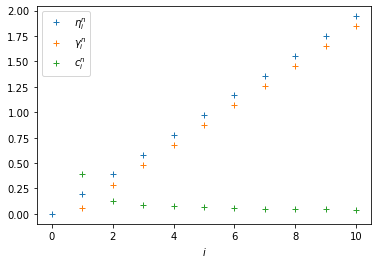

In [ ]:
# Checks
plt.plot(np.arange(n + 1), eta_n, '+', label = r"$\eta_i^n$")
plt.plot(np.arange(1, n + 1), gamma_n, '+', label = r"$\gamma_i^n$")
plt.plot(np.arange(1, n + 1), c_n, '+', label = r"$c_i^n$")
plt.xlabel(r"$i$")
plt.legend(loc = 'best')
plt.show()

## Generation of $V_t^{n,i}$ and $S_t^n$

### Auxiliary matrix

In [ ]:
# A useful matrix
def generate_inverse_matrix_differences(): # this matrix M will have shape (m + 1, m), so that M multiplied by [X1 - X0, ..., Xm - X(m-1)] will give [0, X1 - X0, X2 - X0, ..., Xm - X0]
  diff_matrix_inverse = np.zeros((m + 1, m))
  for i in range (1, m + 1):
    for j in range (i):
      diff_matrix_inverse[i, j] = 1
  return diff_matrix_inverse

diff_matrix_inverse = generate_inverse_matrix_differences()

### Computation of $g^n(t)$ for all $t$

In [ ]:
def compute_gn(n, c_n, gamma_n): #
    t = np.array([[dt * i for i in range (m + 1)] for _ in range (n)])
    return V0 + theta * np.sum(c_n * (1 - np.exp(-gamma_n * t.T)) / gamma_n, axis = 1)

gn = compute_gn(n, c_n, gamma_n)

### Simulation of $V_t^n$ and $S_t^n$

In [ ]:
def generate_V_S(n, c_n, gamma_n):
    # brownian motions
    dW  = np.random.normal(0, dt ** 0.5, m)
    dW_bar = np.random.normal(0, dt ** 0.5, m)
    dB = rho * dW + ((1 - rho ** 2) ** 0.5) * dW_bar

    # computing g_n(t) for all t
    gn = compute_gn(n, c_n, gamma_n)

    # computing V
    Vi = np.zeros((n, m + 1))
    V = gn.copy()

    for k in range (m):
        #Vi[:, k + 1] = Vi[:, k] + (-gamma_n * Vi[:, k] - lambd * V[k]) * dt + nu * (max(V[k],0) ** 0.5) * dB[k]
        Vi[:, k + 1] =( Vi[:, k] - lambd * V[k] * dt + nu * (max(V[k],0) ** 0.5) * dB[k])/(1+gamma_n*dt)
        V[k + 1] += np.sum(c_n * Vi[:, k + 1])

    # computing S
    # X denotes log(S)

    dX = - 0.5 * dt * np.maximum(0, V[:m]) + np.sqrt(np.maximum(0, V[:m])) * dW # dX = [X1 - X0, ..., Xm - X(m-1)]
    X = diff_matrix_inverse @ dX + np.log(S0) * np.ones((m + 1)) # X = [X0, ..., Xm]
    S = np.exp(X)

    return S, V, Vi

In [ ]:
def plot_V_S(n, c_n, gamma_n):
  S, V, Vi = generate_V_S(n, c_n, gamma_n)
  t = np.arange(0, T + dt, dt)
  plt.plot(t, S)
  plt.title(r"Plotting $S_t^n$ with $n = " + str(n) + " $")
  plt.xlabel(r"Time $t$")
  plt.ylabel(r"$S_t^n$")
  plt.show()

  plt.plot(t, V)
  plt.title(r"Plotting $V_t^n$ with $n = " + str(n) + " $")
  plt.xlabel(r"Time $t$")
  plt.ylabel(r"$V_t^n$")
  plt.show()

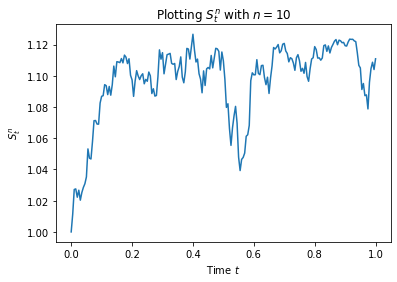

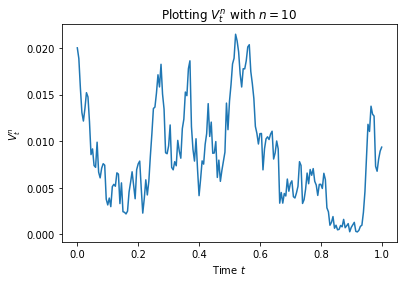

In [ ]:
plot_V_S(n, c_n, gamma_n)

## Fractionnal riccati equation

### Computation of $\psi^n(t, z)$ for all $t$

In [ ]:
def F(z, x):
    return 0.5 * (z ** 2 - z) + (rho * nu * z - lambd) * x + 0.5 * (nu ** 2) * (x ** 2)

In [ ]:
def generate_psi_n(z, n, c_n, gamma_n):
    psi_n_i = np.zeros((n, m + 1), dtype = complex)
    psi_n = np.zeros(m + 1, dtype = complex)

    for k in range (m):
        psi_n_i[:, k + 1] = (psi_n_i[:, k] + F(z, psi_n[k]) * dt) / (1 + gamma_n * dt)
        psi_n[k + 1] = np.sum(c_n * psi_n_i[:, k + 1])

    return psi_n, psi_n_i

### Computation of $\psi(t, z)$ for all $t$

In [ ]:
def generate_matrix_a():
  alpha = H + 0.5
  a = np.ones((m + 1, m + 1)) * (1 / mt.gamma(alpha + 2)) * dt ** alpha
  for k in range (m):
    a[0, k + 1] *= (k ** (alpha + 1) - (k - alpha) * (k + 1) ** alpha)
    for j in range (1, k + 1):
      a[j, k + 1] *= (k - j + 2) ** (alpha + 1) + (k - j) ** (alpha + 1) - 2 * (k - j + 1) ** (alpha + 1)
  return a

In [ ]:
def generate_matrix_b():
  alpha = H + 0.5
  b = np.ones((m + 1, m + 1)) * (1 / mt.gamma(alpha + 1)) * dt ** alpha
  for k in range (m):
    for j in range (k + 1):
      b[j, k + 1] *= (k - j + 1) ** alpha - (k - j) ** alpha
  return b

In [ ]:
a, b = generate_matrix_a(), generate_matrix_b()

In [ ]:
def generate_psi_adams(z):
  psi = np.zeros(m + 1, dtype = complex)
  for k in range (m):
    psi_predicted = np.sum(b[:k + 1, k + 1] * F(z, psi[:k + 1]))
    psi[k + 1] = np.sum(a[:k + 1, k + 1] * F(z, psi[:k + 1])) + a[k + 1, k + 1] * F(z, psi_predicted)
  return psi

### Plotting $\psi(t, z)$ and $\psi^n(t, z)$ in the same graph

In [ ]:
def plot_psi_adams_and_different_n(z, list_n):
  t = np.arange(0, T + dt, dt)

  for n in list_n:
    pi_n, eta_n, c_n, gamma_n = generate_pi_eta_c_gamma(n)
    psi_n, psi_n_i = generate_psi_n(z, n, c_n, gamma_n)
    plt.plot(t, np.abs(psi_n), label = r"$n = " + str(n) + "$")
  psi = generate_psi_adams(z)
  plt.plot(t, np.abs(psi), label = r"Adams scheme", linestyle = 'dashed')
  plt.title(r"Plotting $|\psi^n(t, z)|$ with $z = " + str(z) + "$ for different values of $n$, and $|\psi(z, t)|$ obtained with Adams scheme")
  plt.xlabel(r"Time $t$")
  plt.ylabel(r"$|\psi^n(t, z)|$ or $|\psi(z, t)|$")
  plt.legend(loc = "best")
  plt.show()

  for n in list_n:
    pi_n, eta_n, c_n, gamma_n = generate_pi_eta_c_gamma(n)
    psi_n, psi_n_i = generate_psi_n(z, n, c_n, gamma_n)
    plt.plot(t, np.real(psi_n), label = r"$n = " + str(n) + "$")
  psi = generate_psi_adams(z)
  plt.plot(t, np.real(psi), label = r"Adams scheme", linestyle = 'dashed')
  plt.title(r"Plotting $\mathcal{Re}(\psi^n(t, z))$ with $z = " + str(z) + "$ for different values of $n$, and $\mathcal{Re}(\psi(z, t))$ obtained with Adams scheme")
  plt.xlabel(r"Time $t$")
  plt.ylabel(r"$\mathcal{Re}(\psi^n(t, z))$ or $\mathcal{Re}(\psi(z, t))$")
  plt.legend(loc = "best")
  plt.show()

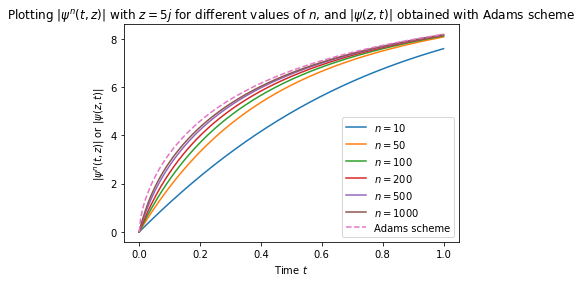

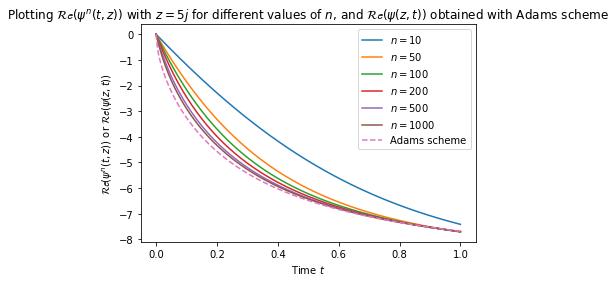

In [ ]:
plot_psi_adams_and_different_n(5 * 1j, np.array([10, 50, 100, 200, 500, 1000]))

### Relative error when approximating $\psi(t, z)$ by $\psi^n(t, z)$

In [ ]:
def plot_relative_error_approximating_psi(list_n, b_max): # approximating psi(T, ib) by psi^n(T, ib)
  list_b = np.linspace(0, b_max, 50)
  psi_ib = np.array([generate_psi_adams(b * 1j)[-1] for b in list_b])
  for n in list_n:
    pi_n, eta_n, c_n, gamma_n = generate_pi_eta_c_gamma(n)
    psi_n_ib = np.array([generate_psi_n(b * 1j, n, c_n, gamma_n)[0][-1] for b in list_b])
    relative_error = np.abs((psi_n_ib - psi_ib) / psi_ib)
    plt.plot(list_b, relative_error, label = r"$n = " + str(n) + "$")
  plt.xlabel(r"$b$")
  plt.ylabel(r"$\left|\frac{\psi^n(T, ib) - \psi(T, ib)}{\psi(T, ib)}\right|$")
  plt.title(r"Relative error when approximating $\psi(T, ib)$ by $\psi^n(T, ib)$ for different values of $b$ and $n$")
  plt.legend(loc = "best")
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


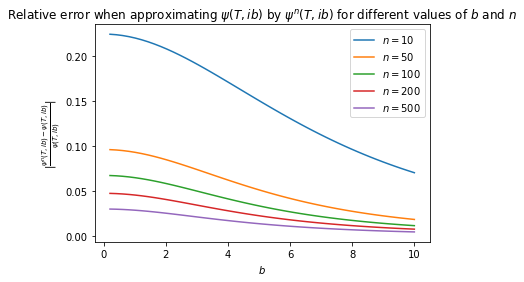

In [ ]:
plot_relative_error_approximating_psi(np.array([10, 50, 100, 200, 500]), 10)

## Pricing

### Computing $L_n(T, z)$ and $L(T, z)$ for all $z$

#### Computing $L_n(T, z)$ for all $z$

In [ ]:
def compute_Ln(t, z, n, c_n, gamma_n, gn): # Calculating L_n(t, T, z)
    imax = int(t / dt)
    psi_n, psi_n_i = generate_psi_n(z, n, c_n, gamma_n)
    F_values = np.array([F(z, psi) for psi in np.flipud(psi_n[:imax + 1])])
    return np.exp(np.sum(dt * F_values * gn[:imax + 1]))

#### Computing $L(T, z)$ for all $z$

In [ ]:
def compute_g():
  return V0 + theta * (1 / mt.gamma(H + 0.5)) * (1 / (H + 0.5)) * np.arange(0, T + dt, dt) ** (H + 0.5)

g = compute_g()

In [ ]:
def compute_L(t, z): # Calculating L(T, z)
    imax = int(t / dt)
    psi = generate_psi_adams(z)
    psi_flip = np.flipud(psi[:imax + 1])
    F_values = F(z, psi_flip)
    return np.exp(np.sum(dt * F_values * g[:imax + 1]))

#### Plotting $L_n(T, z)$ and $L(T, z)$ on the same graph for different values of $n$ and $z$

In [ ]:
def plot_L_approximating_psi(list_n, b_max): # approximating L(T, ib) by L_n(T, ib)
  list_b = np.linspace(0, b_max, 50)
  for n in list_n:
    pi_n, eta_n, c_n, gamma_n = generate_pi_eta_c_gamma(n)
    L_n_ib = np.array([compute_Ln(T, b * 1j, n, c_n, gamma_n, compute_gn(n, c_n, gamma_n)) for b in list_b])
    plt.plot(list_b, np.real(L_n_ib), label = r"$n = " + str(n) + "$")
  L_ib = np.array([compute_L(T, b * 1j) for b in list_b])
  plt.plot(list_b, np.real(L_ib), label = "Adams")
  plt.xlabel(r"$b$")
  plt.ylabel(r"$\mathcal{Re}(\L_n(T, ib))$ or $\mathcal{Re}(L(T, ib))$")
  plt.title(r"Approximating $L(T, ib)$ by $L_n(T, ib)$ for different values of $b$ and $n$")
  plt.legend(loc = "best")
  plt.show()

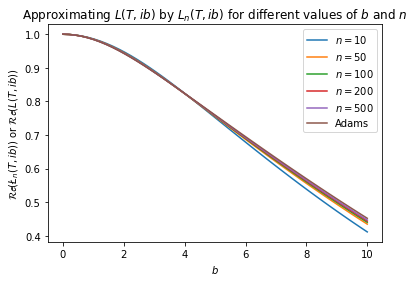

In [ ]:
plot_L_approximating_psi(np.array([10, 50, 100, 200, 500]), 10)

## Comparing $L(T, z)$ with the Monte-Carlo approximation of $\mathbb{E}[\exp(z\log(S_T/S_0))]$

In [ ]:
def MC_L(list_z, nb_simulations, n):
  pi_n, eta_n, c_n, gamma_n = generate_pi_eta_c_gamma(n)
  number_z = list_z.shape[0]
  monte_carlo_L = np.zeros(number_z, dtype = complex)
  for _ in range(nb_simulations):
    S, V, Vi = generate_V_S(n, c_n, gamma_n)
    monte_carlo_L += np.exp(list_z * np.log(S[-1] / S0))
  return monte_carlo_L / nb_simulations

def plot_comparing_L_monte_carlo(list_n, b_max, nb_simulations):
  list_b = np.linspace(0, b_max, 20)
  for n in tqdm(list_n):
    L_n_MC_ib = MC_L(list_b * 1j, nb_simulations, n)
    plt.plot(list_b, np.real(L_n_MC_ib), label = r"$n = " + str(n) + "$")
  L_ib = np.array([compute_L(T, b * 1j) for b in list_b])
  plt.plot(list_b, np.real(L_ib), label = "Adams")
  plt.xlabel(r"$b$")
  plt.ylabel(r"$\mathcal{Re}(\L_{n, MC}(T, ib))$ or $\mathcal{Re}(L(T, ib))$")
  plt.title(r"Approximating $L(T, ib)$ by $L_{n, MC}(T, ib)$ for different values of $b$ and $n$")
  plt.legend(loc = "best")
  plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

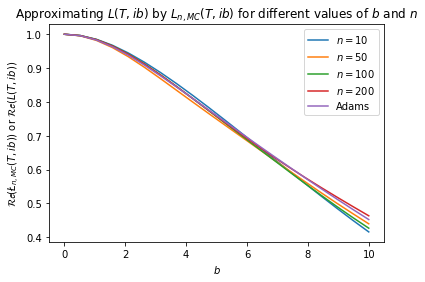

In [ ]:
plot_comparing_L_monte_carlo(np.array([10, 50, 100, 200]), 10, 2000)

## Pricing European options

### Computing the price of European options based on $L$

In [ ]:
def price_call_quad(maturity, k):
  k_article = -k
  strike  = S0 * np.exp(k)
  def integrand(u):
    return np.real(np.exp(u * k_article * 1j) * compute_L(maturity, 1j * (u - 0.5j)) * (1 / (u ** 2 + 0.25)))
  return S0 - (1 / mt.pi) * (S0 * strike) ** 0.5 * integr.quad(integrand, 0, 100)[0]

In [ ]:
price_call_quad(T, 0.1)

0.013681169220865486

In [ ]:
def price_call_quad_n(maturity, k, n, c_n, gamma_n, gn):
  k_article = -k
  strike  = S0 * np.exp(k)
  def integrand(u):
    return np.real(np.exp(u * k_article * 1j) * compute_Ln(maturity, (1j * (u - 0.5j)), n, c_n, gamma_n, gn) * (1 / (u ** 2 + 0.25)))
  return S0 - (1 / mt.pi) * (S0 * strike) ** 0.5 * integr.quad(integrand, 0, 100)[0]

In [ ]:
price_call_quad_n(T, 0.1, n, c_n, gamma_n, gn)

0.015273058768042858

### Computing implied volatilities

#### Black-Scholes model

In [ ]:
def black_scholes(volatility, K, maturity): # K is the strike, t is the maturity
    v = maturity * (volatility ** 2)
    dplus = np.log(S0 / K) / (v ** 0.5) + 0.5 * (v ** 0.5)
    dminus = np.log(S0 / K) / (v ** 0.5) - 0.5 * (v ** 0.5)
    return S0 * ssn.norm.cdf(dplus) - K * ssn.norm.cdf(dminus)

In [ ]:
def plot_black_scholes(K):
  volatilities = np.array([i / 100 for i in range (1, 1001)])
  options = np.array([black_scholes(volatility, K, 1) for volatility in volatilities])
  plt.xlabel(r"Volatility $\sigma_{BS}$")
  plt.title(r"Price of the European option with volatility $v$ and strike $K = " + str(K) +"$")
  plt.plot(volatilities, options)
  plt.show()

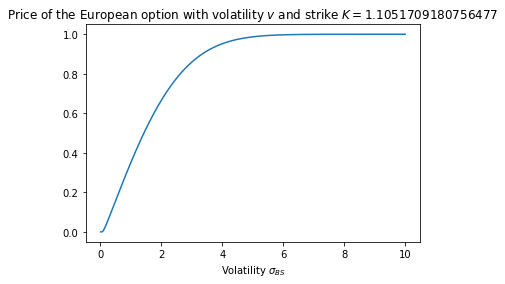

In [ ]:
plot_black_scholes(np.exp(0.1))

#### Inverting Black-Scholes

In [ ]:
def invert_black_scholes(K, maturity, option_price, inf_volatility = 1e-20, sup_volatility = 100):
  f = lambda volatility : black_scholes(volatility, K, maturity) - option_price
  return scipy.optimize.bisect(f, inf_volatility, sup_volatility)

### Estimation of $\sigma_{BS}(k, T)$ (implied volatility when pricing a European option with log-strike $k$ and maturity $T = 1$)

In [ ]:
def implied_volatility(maturity, k): # One log-strike and one maturity
  K = S0 * np.exp(k)
  option_price = price_call_quad(maturity, k)
  return invert_black_scholes(K, maturity, option_price)

In [ ]:
def plot_implied_volatility(inf_k, sup_k, number_k): # number_k is the number of k for which we are launching those simulations
  list_k = np.linspace(inf_k, sup_k, number_k)
  implied_volatilities = np.array([implied_volatility(T, k) for k in list_k])
  plt.xlabel(r"Log-strike $k$")
  plt.ylabel(r"Implied volatility $\sigma_{BS}(k, T)$ with $T = 1$")
  plt.title(r"Computing $\sigma_{BS}(k, T)$ with $T = 1$ with $L$ and $\psi$ derived from Adams scheme")
  plt.plot(list_k, implied_volatilities)
  plt.show()

In [ ]:
def implied_volatility_n(maturity, k, n, c_n, gamma_n, gn): # One log-strike and one maturity
  K = S0 * np.exp(k)
  option_price = price_call_quad_n(maturity, k, n, c_n, gamma_n, gn)
  return invert_black_scholes(K, maturity, option_price)

In [ ]:
def plot_implied_volatility_different_n(inf_k, sup_k, number_k, list_n):
  list_k = np.linspace(inf_k, sup_k, number_k)
  for n in tqdm(list_n):
    pi_n, eta_n, c_n, gamma_n = generate_pi_eta_c_gamma(n)
    gn = compute_gn(n, c_n, gamma_n)
    implied_volatilities_n = np.array([implied_volatility_n(T, k, n, c_n, gamma_n, gn) for k in list_k])
    plt.plot(list_k, implied_volatilities_n, label = r"$n = " + str(n) + "$")
  implied_volatilities = np.array([implied_volatility(T, k) for k in list_k])
  plt.plot(list_k, implied_volatilities, label = r"Adams")
  plt.xlabel(r"Log-strike $k$")
  plt.ylabel(r"Implied volatility $\sigma_{BS}(k, T)$ or $\sigma_{BS}^n(k, T)$ with $T = 1$")
  plt.title(r"Computing $\sigma_{BS}(k, T)$ and $\sigma_{BS}^n(k, T)$ with $T = 1$")
  plt.legend(loc = "best")
  plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

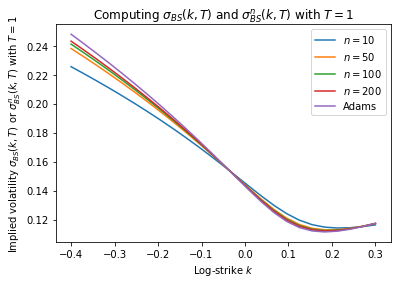

In [ ]:
plot_implied_volatility_different_n(-0.4, 0.3, 25, np.array([10, 50, 100, 200]))

### Plotting ATM (at-the-money) volatility skew $\psi(\tau)$

#### Plotting $\psi(\tau) = f(\tau)$

In [ ]:
def plot_at_the_money_skew_reusing_simulations_old(min_maturity, max_maturity, number_maturities, epsilon, list_n):
  # maturities is a list of maturities, epsilon is the value of k used to compute the derivative at k = 0...
  maturities = np.linspace(min_maturity, max_maturity, number_maturities)

  skews_n = np.zeros(number_maturities)
  for n in tqdm(list_n):
    pi_n, eta_n, c_n, gamma_n = generate_pi_eta_c_gamma(n)
    gn = compute_gn(n, c_n, gamma_n)
    for i in tqdm(range(number_maturities)):
      skews_n[i] = np.abs((implied_volatility_n(maturities[i], epsilon, n, c_n, gamma_n, gn) - implied_volatility_n(maturities[i], -epsilon, n, c_n, gamma_n, gn)) / (2 * epsilon))
    plt.plot(maturities, skews_n, label = r"$n = " + str(n) + "$")

  skews = np.zeros(number_maturities)
  for i in tqdm(range(number_maturities)):
    skews[i] = np.abs((implied_volatility(maturities[i], epsilon) - implied_volatility(maturities[i], -epsilon)) / (2 * epsilon))
  plt.plot(maturities, skews, label = r"Adams")

  plt.xlabel(r"Maturity $\tau$")
  plt.ylabel(r"At the money volatility skew $\psi(\tau)$")
  plt.legend(loc = "best")
  plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

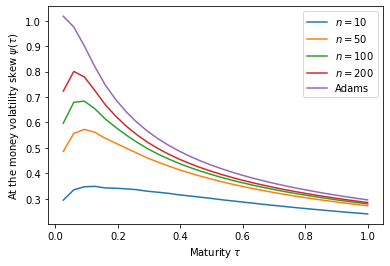

In [ ]:
plot_at_the_money_skew_reusing_simulations_old(0.025, 1, 30, 1e-7, np.array([10, 50, 100, 200]))

In [ ]:
def plot_at_the_money_skew_reusing_simulations(min_maturity, max_maturity, number_maturities, epsilon, list_n):
  # maturities is a list of maturities, epsilon is the value of k used to compute the derivative at k = 0...
  maturities = np.linspace(min_maturity, max_maturity, number_maturities)

  skews_n = np.zeros(number_maturities)
  for n in tqdm(list_n):
    pi_n, eta_n, c_n, gamma_n = generate_pi_eta_c_gamma(n)
    for i in tqdm(range(number_maturities)):
      gn = compute_gn(n, c_n * (T / maturities[i]) ** (0.5 - H), gamma_n * (T / maturities[i]) ** (1.5 - H))
      skews_n[i] = np.abs((implied_volatility_n(maturities[i], epsilon, n, c_n * (T / maturities[i]) ** (0.5 - H), gamma_n * (T / maturities[i]) ** (1.5 - H), gn) - implied_volatility_n(maturities[i], -epsilon, n, c_n * (T / maturities[i]) ** (0.5 - H), gamma_n * (T / maturities[i]) ** (1.5 - H), gn)) / (2 * epsilon))
    plt.plot(maturities, skews_n, label = r"$n = " + str(n) + "$")

  skews = np.zeros(number_maturities)
  for i in tqdm(range(number_maturities)):
    skews[i] = np.abs((implied_volatility(maturities[i], epsilon) - implied_volatility(maturities[i], -epsilon)) / (2 * epsilon))
  plt.plot(maturities, skews, label = r"Adams")

  plt.xlabel(r"Maturity $\tau$")
  plt.ylabel(r"At the money volatility skew $\psi(\tau)$")
  plt.legend(loc = "best")
  plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

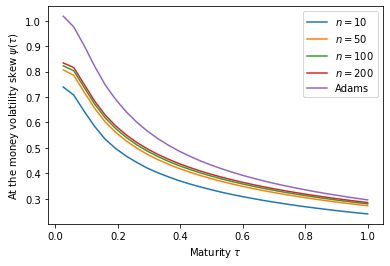

In [ ]:
plot_at_the_money_skew_reusing_simulations(0.025, 1, 30, 1e-7, np.array([10, 50, 100, 200]))

#### Plotting $\log(\psi(\tau)) = f(\log(\tau))$

In [ ]:
def plot_log_at_the_money_skew_reusing_simulations(min_maturity, max_maturity, number_maturities, epsilon, list_n):
  # maturities is a list of maturities, epsilon is the value of k used to compute the derivative at k = 0...
  maturities = np.linspace(min_maturity, max_maturity, number_maturities)

  skews_n = np.zeros(number_maturities)
  for n in tqdm(list_n):
    pi_n, eta_n, c_n, gamma_n = generate_pi_eta_c_gamma(n)
    for i in tqdm(range(number_maturities)):
      gn = compute_gn(n, c_n * (T / maturities[i]) ** (0.5 - H), gamma_n * (T / maturities[i]) ** (1.5 - H))
      skews_n[i] = np.abs((implied_volatility_n(maturities[i], epsilon, n, c_n * (T / maturities[i]) ** (0.5 - H), gamma_n * (T / maturities[i]) ** (1.5 - H), gn) - implied_volatility_n(maturities[i], -epsilon, n, c_n * (T / maturities[i]) ** (0.5 - H), gamma_n * (T / maturities[i]) ** (1.5 - H), gn)) / (2 * epsilon))
    plt.plot(np.log(maturities), np.log(skews_n), label = r"$n = " + str(n) + "$")

  skews = np.zeros(number_maturities)
  for i in tqdm(range(number_maturities)):
    skews[i] = np.abs((implied_volatility(maturities[i], epsilon) - implied_volatility(maturities[i], -epsilon)) / (2 * epsilon))
  plt.plot(np.log(maturities), np.log(skews), label = r"Adams")

  plt.xlabel(r"Log-maturity $\log(\tau)$")
  plt.ylabel(r"At the money volatility log-skew $\log(\psi(\tau))$")

  # Linear regression
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(maturities), np.log(skews))
  plt.plot(np.log(maturities), np.log(maturities) * slope + intercept, label = r"Linear regression: $" + str(round(slope, 3)) + "\log(\\tau) + (" + str(round(intercept, 3)) + ")$", linestyle = "dashed")
  plt.legend(loc = "best")
  plt.show()
  print("r = ", r_value)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

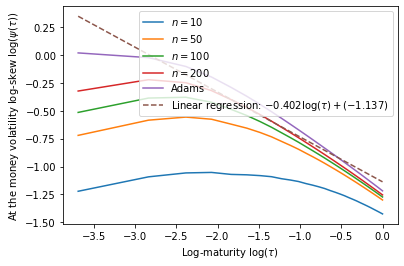

r =  -0.9726608893591207


In [ ]:
plot_log_at_the_money_skew_reusing_simulations(0.025, 1, 30, 1e-7, np.array([10, 50, 100, 200]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

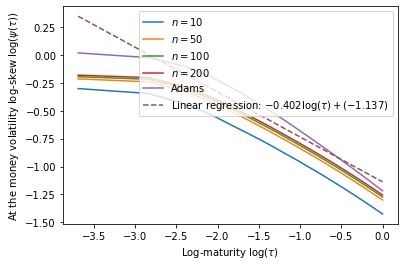

r =  -0.9726608893591207


In [ ]:
plot_log_at_the_money_skew_reusing_simulations(0.025, 1, 30, 1e-7, np.array([10, 50, 100, 200]))